In [2]:
import pandas as pd
import numpy as np
from numpy import polyfit
import xgboost as xgb
from xgboost import plot_tree
import time
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import operator
import collections
import warnings
warnings.filterwarnings("ignore")

In [3]:
tst = pd.DataFrame({'a':[1, np.nan, 3, 4], 'b':[2, 4, np.nan, 8]})

数据读取，一开始并没有dt12, dt34两个文件，是处理后生成的

In [4]:
path = 'data/data71729/'
train_label = pd.read_csv(path + 'train_label.csv')
to_pred = pd.read_csv(path + 'to_pred_a.csv')
submit = pd.read_csv(path + 'submit_a.csv')
data = pd.read_csv(path + 'data_a.csv')

In [6]:
datatr12 = pd.read_csv('dt12.csv')
datats34 = pd.read_csv('dt34.csv')

常用特征符号

In [7]:
mff = 'monfix_fee'
gam = 'gift_acct_amt'
acf = 'actvcall_fee'
oacf = 'out_activcall_fee'
oacd = 'out_actvcall_dur'
gi = 'if_group'
fi = 'if_family'
gprf = 'gprs_fee'
ogprf = 'overrun_flux_fee'
smsi = 'sms_inpkg_ind'
psf = 'p2psms_pkg_fee'
pcf = 'p2fsms_cmnct_fee'

主要函数

In [1]:
# 两个数据集连续型特征的分布比较
def hist_2df(df1, df2, col,bs=20):
    t1 = df1[col].dropna()
    t2 = df2[col].dropna()
    tmp = pd.DataFrame({'df1': t1, 'df2': t2})
    tmp.plot.hist(bins=bs,alpha=0.5, title=col)

# 两个数据集离散特征的分布比较
def countplot_2df(df1, df2, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.countplot(data=df1, x=col, order=df1[col].value_counts().index, ax=ax1).set_title('df1')
    sns.countplot(data=df2, x=col, order=df2[col].value_counts().index, ax=ax2).set_title('df2')

# 统计特征函数
def minval(x, y):
    return min(x, y)
def maxval(x, y):
    return max(x, y)
def meanval(x, y):
    if np.isnan(x):
        return y
    if np.isnan(y):
        return x
    return (x + y) / 2
def catsval(x, y):
    if np.isnan(x):
        return y
    if np.isnan(y):
        return x
    return x + y

# 验证训练分数
def f1score(yp, yval):
    cm = confusion_matrix(yp,yval)
    print(cm)
    rate = 2 * cm[1,1] / (2 * cm[1,1] + cm[1,0] + cm[0,1])
    return rate
def pdf1(r, pred='pred', label='label'):
    return f1score([1 if p > r else 0 for p in datatr12[pred]], datatr12[label].values)

# 两个数据集的差异大小和影响因素
def diff_trs(tr, ts, cols, label='trslabel'):
    tr = tr[cols]
    ts = ts[cols]
    tr[label] = 1
    ts[label] = 0
    trs = pd.concat([tr, ts])
    clf = xgb.XGBClassifier( 
        n_estimators=200,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
    )
    clf.fit(trs[cols].values, trs[label].values)
    yp = clf.predict(trs[cols].values)
    imp = clf.get_booster().get_fscore()
    impres = {}
    for i in range(len(cols)):
        nm = 'f' + str(i)
        if nm in imp:
            impres[cols[i]] = imp[nm]
    res = sorted(impres.items(), key=lambda x: x[1], reverse=True)
    return roc_auc_score(trs[label].values, yp), dict(res)

# xgb可视化
def xgbplot(df, cols, label='label', a=40, b=10):
    clf = xgb.XGBClassifier( 
        n_estimators=200,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
    )
    clf.fit(df[cols], df[label])
    rcParams['figure.figsize'] = a, b
    plot_tree(clf)
    return clf

# xgb5折模型训练
def xgbclf(train, test, init_cols, label='label', trnm='pred', tsnm='pred'):
    res = 0
    trainproba = np.zeros(len(train))
    pred = np.zeros(len(test))
    Xy_train = train[init_cols+[label]]
    X_test = test[init_cols]

    y_train = train[label]
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        # objective='multi:softmax',
        # num_class=train[label].nunique(),
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        # missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
    )

    folds = KFold(n_splits=5, shuffle=True, random_state=2020)
    importance = collections.defaultdict(list)
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(Xy_train)):
        # print("fold {}:".format(fold_ + 1))
        xytrain = Xy_train.iloc[trn_idx]
        xyval = Xy_train.iloc[val_idx]
        # fraudtrain = xytrain[xytrain[label] == 1]
        # for i in range(fraud_strength):
        #     xytrain = pd.concat([xytrain,fraudtrain])    
        xtrain, ytrain = xytrain.loc[:,init_cols].values, xytrain.loc[:, label].values
        xval, yval = xyval.loc[:,init_cols].values, xyval.loc[:, label].values
        clf.fit(xtrain, ytrain, eval_set=[(xval,yval)], early_stopping_rounds=100, verbose=0)
        # 预测train的val_idx
        yp = clf.predict(xval,ntree_limit=clf.best_ntree_limit)
        imp = clf.get_booster().get_fscore()
        for k, v in imp.items():
            importance[k].append(v)

        trainproba[val_idx] = clf.predict_proba(xval, ntree_limit=clf.best_ntree_limit)[:, 1]
        cm = confusion_matrix(yp,yval)
        print(cm)
        rate = 2 * cm[1,1] / (2 * cm[1,1] + cm[1,0] + cm[0,1])
        # rate = precision_score(yp, yval, average='macro')
        res += rate
        # 预测test
        pred += clf.predict(X_test.values, ntree_limit=clf.best_ntree_limit) / folds.n_splits

    
    test[tsnm] = pred
    train[trnm] = trainproba
    impres = {}
    for i in range(len(init_cols)):
        nm = 'f' + str(i)
        if nm in imp:
            impres[init_cols[i]] = np.mean(imp[nm])
    impres = sorted(impres.items(), key=lambda x: x[1], reverse=True)
    return res / folds.n_splits, dict(impres)

**1. 数据探索**

本次数据集空值处理是比较值得注意的地方，不能随意进行填充，对if_family, if_group, call_cnt这三列的填充0操作是有明确意义的。
if_family, if_group是二元变量，空值即代表“非”。
call_cnt代表访问次数，数据中包含大于0的整数以及空值，空值自然也就代表0次。

In [111]:
data['if_family'] = data['if_family'].apply(lambda x: 1 if x == '1' else 0)
data['if_group'] = data['if_group'].apply(lambda x: 1 if x == '1' else 0)


In [112]:
def obj2float(x):
    if x == '\\N':
        return np.nan
    return float(x)
for c in data.columns:
    if c != 'phone' and data[c].dtype == 'object':
        data[c] = data[c].apply(obj2float)


In [113]:
data['call_cnt'] = data.call_cnt.fillna(0)

开始想采用相关性强的特征对空值进行填充，但由于本次数据集中含有不同的通信套餐，而不同的通信套餐恰好包含羊毛党倾向选择的套餐信息，因此不能采用利用其它特征进行回归预测的方法填充空值。

In [ ]:
# def nan_polyfit(cx, cy, coef):
#     if not np.isnan(cx) and np.isnan(cy):
#         return coef[0] * cx + coef[1]
#     else:
#         return cy
# data_nn = data.dropna()
# c = 'actvcall_fee'
# c1, c2 = 'out_activcall_fee', 'out_actvcall_dur'
# cto1 = polyfit(data_nn[c].values, data_nn[c1].values, 1)
# cto2 = polyfit(data_nn[c].values, data_nn[c2].values, 1)
# data[c1] = data.apply(lambda df: nan_polyfit(df[c], df[c1], cto1), axis=1)
# data[c2] = data.apply(lambda df: nan_polyfit(df[c], df[c2], cto2), axis=1)

**分割训练集和测试集**  
这里的分割仅用于数据探索。

In [9]:
data1 = data.merge(train_label, on='phone', how='left')
datatr = data1[~data1['label'].isnull()]
datats = data1[data1['label'].isnull()]
datatr1 = datatr[datatr['month'] == 202001]
datatr2 = datatr[datatr['month'] == 202002]
datatr1.sort_values(by=['phone'], inplace=True)
datatr2.sort_values(by=['phone'], inplace=True)

datats3 = datats[datats['month'] == 202003]
datats4 = datats[datats['month'] == 202004]
datats3.sort_values(by=['phone'], inplace=True)
datats4.sort_values(by=['phone'], inplace=True)

**特征之间的相关性分析**

In [ ]:
tmp = datatr.corr()
sets = set()
for c1 in tmp.columns:
    for c2 in tmp.columns:
        if c1 != c2 and abs(tmp.loc[c1, c2]) > 0.5 and (c2, c1) not in sets:
            print(c1, c2, tmp.loc[c1, c2])
            sets.add((c1, c2))


chrg_cnt chrg_amt 0.6589645615713099
gprs_fee overrun_flux_fee 0.5334301109989747
out_actvcall_dur actvcall_fee 0.9211248363071871
out_actvcall_dur out_activcall_fee 0.5231326835116051
actvcall_fee out_activcall_fee 0.5336057092737385
call_cnt up_flux 0.692180088738326
up_flux down_flux 0.6128819565907504
sms_inpkg_ind p2psms_pkg_fee 0.6858515219958965
p2psms_up_cnt p2psms_cmnct_fee 0.8860686134082176


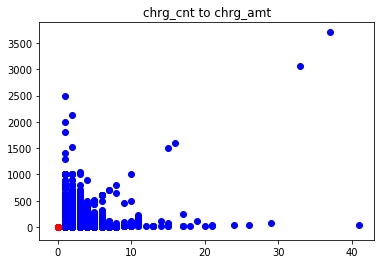

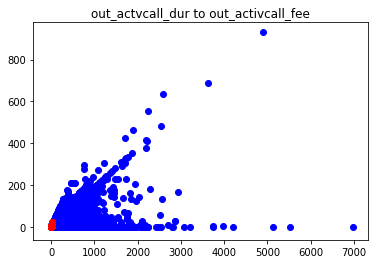

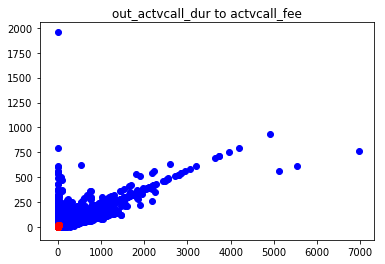

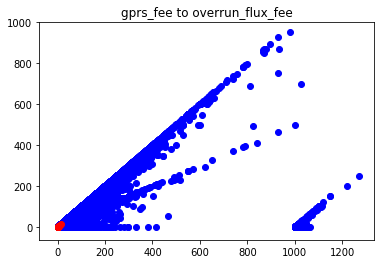

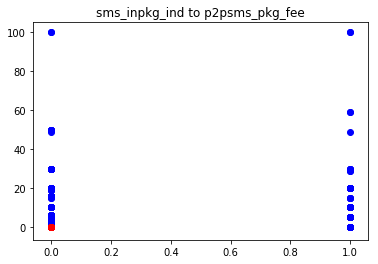

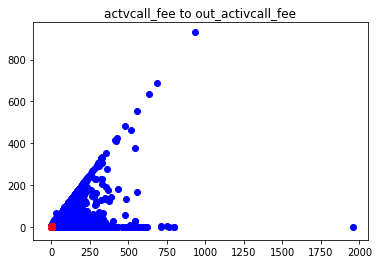

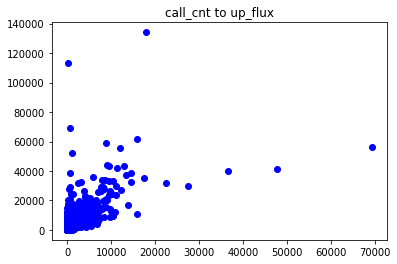

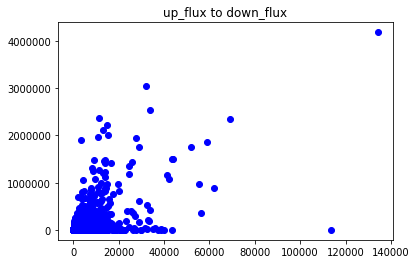

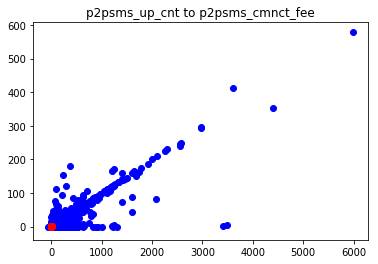

In [ ]:
tmp0 = datatr[datatr['label'] == 0]
tmp1 = datatr[datatr['label'] == 1]
for c1, c2 in sets:
    plt.title(c1 + ' to ' + c2 )
    plt.scatter(tmp0[c1], tmp0[c2], c='b')
    plt.scatter(tmp1[c1], tmp1[c1], c='r')
    plt.show()

上面可以看出,相关性强的特征，诸如短信资费和发送短信条数，通话费用和通话时长呈较强的线性关系，且在它们的散点图中，可以看到多条线段。这与我们认知相符，费用 = 单位计价 * 时长，而不同的套餐有不同的计费方式。
值得注意的有两组特征的关系：  
1.流量费用与超额流量费用间的关系。可以注意到虽然有存在多种线性回归方式，但超额流量费与流量费之比不会超过1。根据经验，可以发现，一些套餐本身不包含流量，因此使用流量费用是多少，超额流量费用就是多少。  
2.呼叫费用与超套呼叫费用的关系。超套呼叫费用与呼叫费用之比不会超过1，和之前一样，有相同的推论。

**探索单个变量中羊毛党的特征**

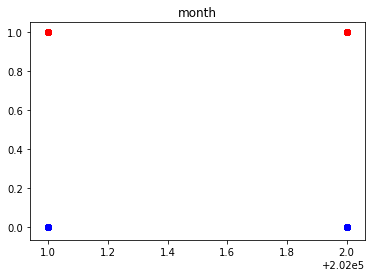

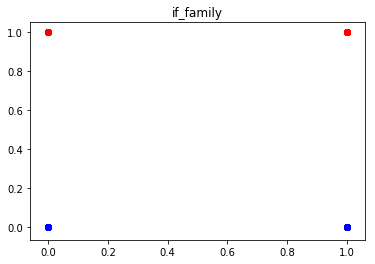

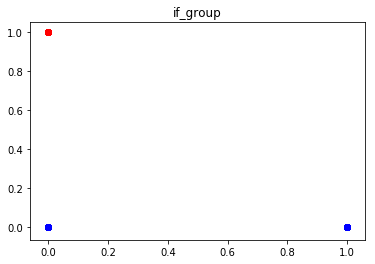

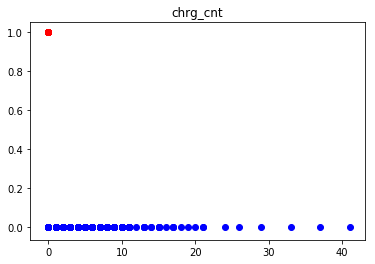

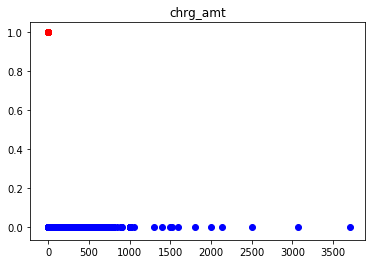

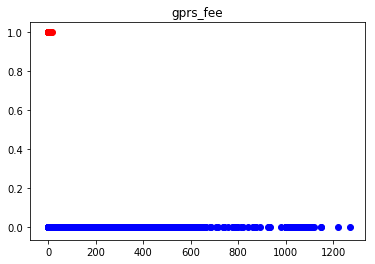

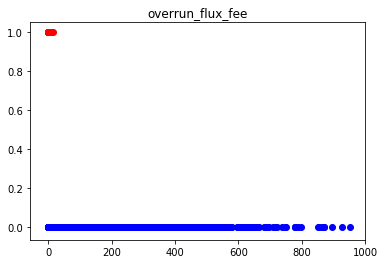

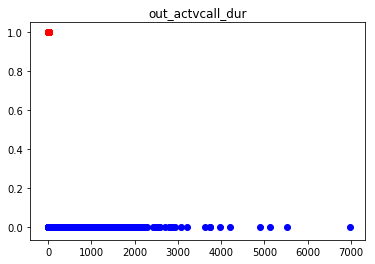

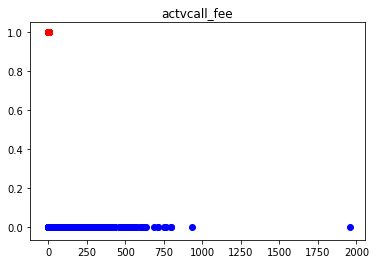

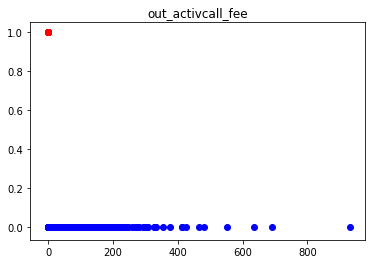

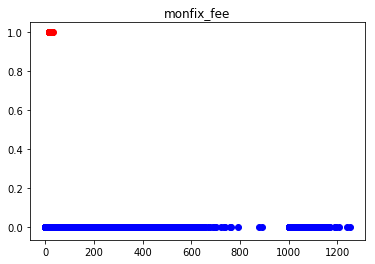

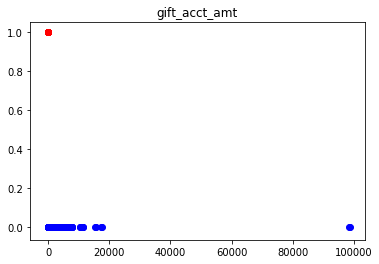

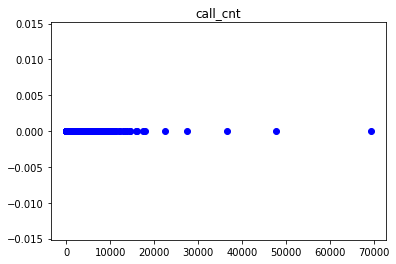

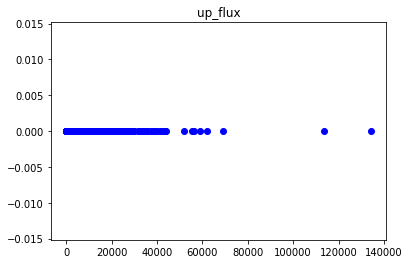

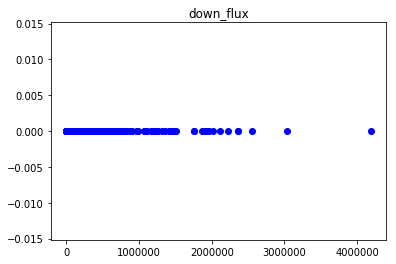

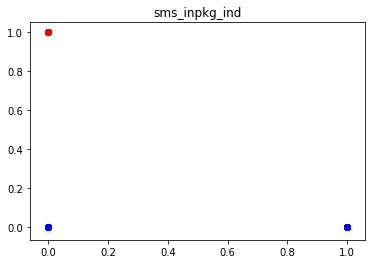

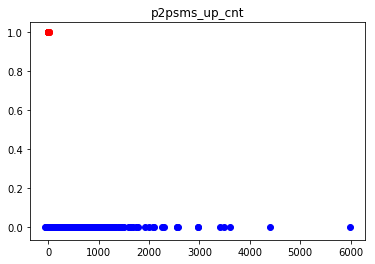

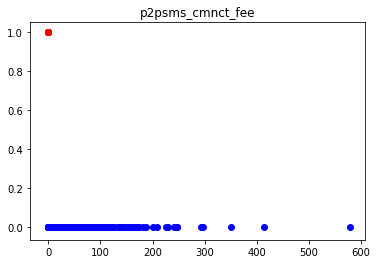

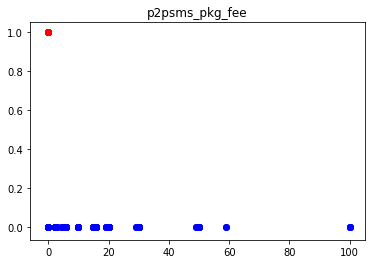

In [ ]:
for col in datatr.columns:
    if col not in ['phone', 'label']:
        plt.title(col)
        plt.scatter(tmp0[col], tmp0['label'], c='b')
        plt.scatter(tmp1[col], tmp1['label'], c='r')
        plt.show()

实际情况中，羊毛党的手机套餐和普通人的有显著区别。为了节约成本，在不参与活动牟利时，他们的账号会保持最低限度的电讯资费来维持账号运行。这与我们的探索结果一致。

**探索训练集中不同月份的差异**  
在实际情况中，羊毛党在特定活动时的表现和平时会有差别，需要考察数据集中不同月份的表现

In [18]:
# 观察哪些特征在两个数据集中差异非常大
s, dic = diff_trs(datatr1, datatr2, tmp)

monfix_fee 88.0 88.0
actvcall_fee 3.23 1.0
out_actvcall_dur 15.0 5.0
p2psms_up_cnt 1.0 0.0
gift_acct_amt 0.0 0.0
p2psms_cmnct_fee 0.0 0.0
if_family 1.0 1.0
out_activcall_fee 0.0 0.0
gprs_fee 10.0 5.0
overrun_flux_fee 0.0 0.0
p2psms_pkg_fee 0.0 0.0
call_cnt 0.0 0.0
chrg_cnt 0.0 0.0
up_flux 115.0 105.0
sms_inpkg_ind 0.0 0.0
chrg_amt 0.0 0.0
down_flux 2176.0 1899.0
if_group 0.0 0.0


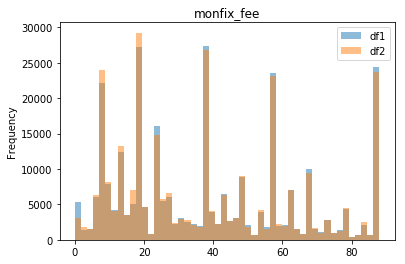

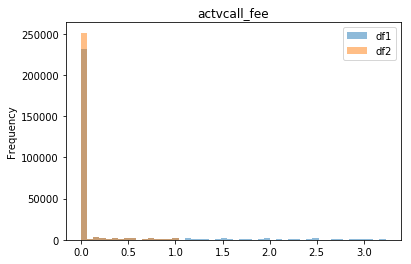

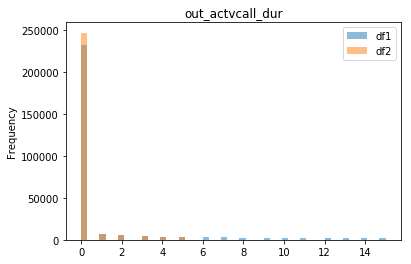

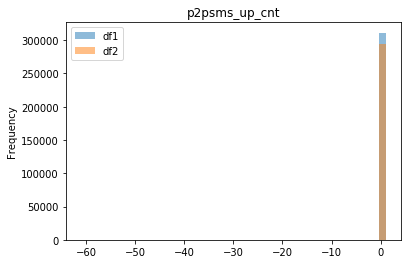

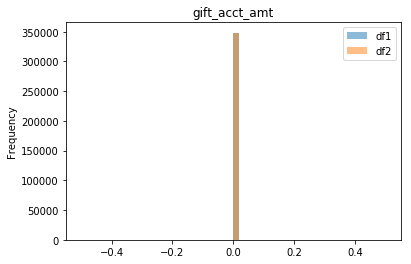

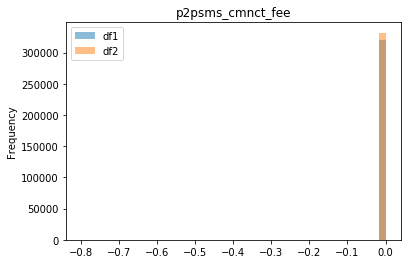

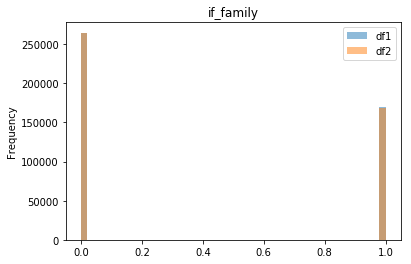

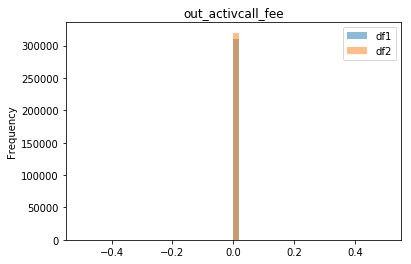

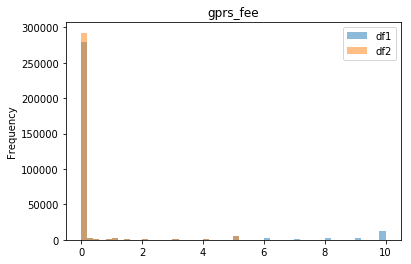

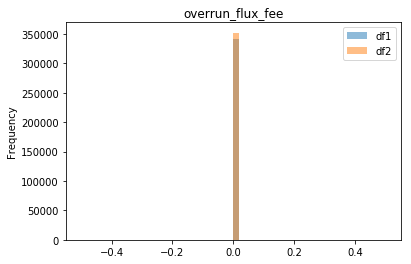

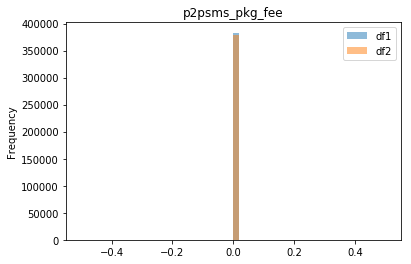

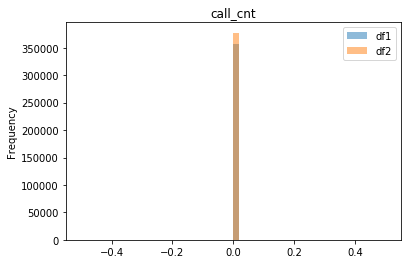

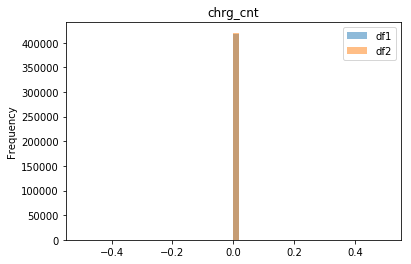

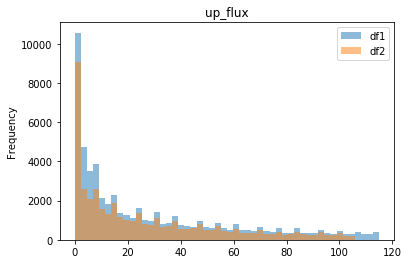

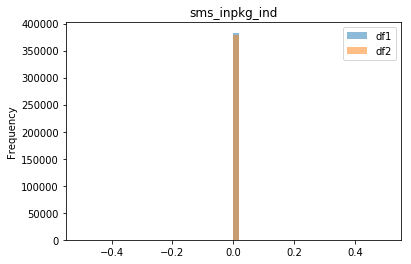

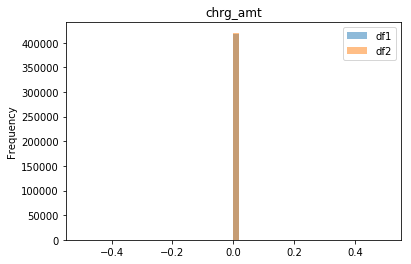

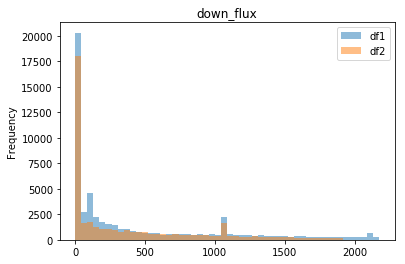

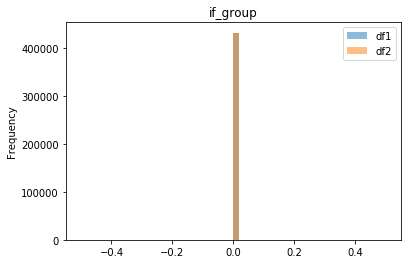

In [72]:
# 单个变量两个月的分布图
for col in dic:
    q1 = datatr1[col].quantile(0.75)
    q2 = datatr2[col].quantile(0.75)
    print(col, q1, q2)
    tmp1 = datatr1[datatr1[col] <= q1]
    tmp2 = datatr2[datatr2[col] <= q2]
    if tmp1.shape[0] == 0 and tmp2.shape[0] == 0:
        continue
    hist_2df(tmp1, tmp2, col, 50)

In [38]:
# 所有原特征
tmp = [c for c in data.columns if c not in ['phone', 'month']]
v1, _ = xgbclf(datatr1, datatr1, tmp)
v2, _ = xgbclf(datatr2, datatr2, tmp)
print(v1, v2)

[[85414    37]
 [  121  1111]]
[[85331    28]
 [  145  1179]]
[[85394   183]
 [   80  1026]]
[[85283    35]
 [  153  1211]]
[[85358    46]
 [  150  1128]]
[[85213    63]
 [  322  1085]]
[[85162    74]
 [  314  1133]]
[[85123    70]
 [  351  1139]]
[[85118    66]
 [  318  1180]]
[[85267   395]
 [  241   779]]
0.9199377411150534 0.8234627522734487


In [39]:
# 去除mff
tmp = [c for c in data.columns if c not in ['phone', 'month', mff]]
v1, _ = xgbclf(datatr1, datatr1, tmp)
v2, _ = xgbclf(datatr2, datatr2, tmp)
print(v1, v2)

[[85501   903]
 [   34   245]]
[[85450   900]
 [   26   307]]
[[85449   927]
 [   25   282]]
[[85405   938]
 [   31   308]]
[[85479   883]
 [   29   291]]
[[85522  1109]
 [   13    39]]
[[85465  1164]
 [   11    43]]
[[85460  1177]
 [   14    32]]
[[85422  1198]
 [   14    48]]
[[85498  1140]
 [   10    34]]
0.3784624885024438 0.06268391619756761


In [40]:
# 去除oacd
tmp = [c for c in data.columns if c not in ['phone', 'month', oacd]]
v1, _ = xgbclf(datatr1, datatr1, tmp)
v2, _ = xgbclf(datatr2, datatr2, tmp)
print(v1, v2)

[[85411    37]
 [  124  1111]]
[[85327    31]
 [  149  1176]]
[[85361   112]
 [  113  1097]]
[[85292    56]
 [  144  1190]]
[[85355    45]
 [  153  1129]]
[[85404   546]
 [  131   602]]
[[85163    76]
 [  313  1131]]
[[85123    71]
 [  351  1138]]
[[85112    65]
 [  324  1181]]
[[85353   502]
 [  155   672]]
0.9220392282967849 0.7734393730834597


In [41]:
# 去除acf
tmp = [c for c in data.columns if c not in ['phone', 'month', acf]]
v1, _ = xgbclf(datatr1, datatr1, tmp)
v2, _ = xgbclf(datatr2, datatr2, tmp)
print(v1, v2)

[[85407    38]
 [  128  1110]]
[[85319    31]
 [  157  1176]]
[[85358   112]
 [  116  1097]]
[[85270    38]
 [  166  1208]]
[[85348    48]
 [  160  1126]]
[[85399   547]
 [  136   601]]
[[85160   100]
 [  316  1107]]
[[85136   114]
 [  338  1095]]
[[85125   109]
 [  311  1137]]
[[85339   480]
 [  169   694]]
0.9199718455874984 0.7667801134031846


In [74]:
# 只用mff
tmp = [mff]
v1, _ = xgbclf(datatr1, datatr1, tmp)
v2, _ = xgbclf(datatr2, datatr2, tmp)
print(v1, v2)

[[84726   146]
 [  809  1002]]
[[84652   172]
 [  824  1035]]
[[84672   150]
 [  802  1059]]
[[84635   168]
 [  801  1078]]
[[84733   147]
 [  775  1027]]
[[85535  1148]
 [    0     0]]
[[85476  1207]
 [    0     0]]
[[85474  1209]
 [    0     0]]
[[85436  1246]
 [    0     0]]
[[85508  1174]
 [    0     0]]
0.6844826105765345 0.0


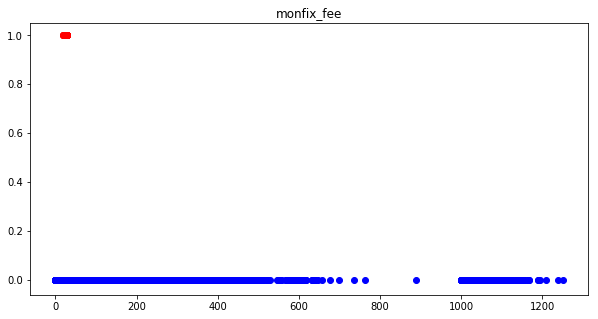

24.0    0.869151
29.0    0.129178
26.0    0.000836
18.0    0.000501
28.0    0.000167
25.0    0.000167
Name: monfix_fee, dtype: float64


38.0     0.071804
18.0     0.064659
88.0     0.064224
58.0     0.061055
8.0      0.059281
68.0     0.023623
48.0     0.019910
93.0     0.019504
14.0     0.018143
23.0     0.017958
63.0     0.017735
138.0    0.017498
43.0     0.016943
98.0     0.015855
6.0      0.015273
13.0     0.014564
10.0     0.013664
108.0    0.013447
28.0     0.013417
16.0     0.011148
Name: monfix_fee, dtype: float64

In [122]:
# 对比两月mff的细节差异
col = mff
tmp0 = datatr1[datatr1['label'] == 0]
tmp1 = datatr1[datatr1['label'] == 1]
plt.title(col)
plt.scatter(tmp0[col], tmp0['label'], c='b')
plt.scatter(tmp1[col], tmp1['label'], c='r')
plt.show()
print(tmp1[col].value_counts(normalize=True))
tmp0[col].value_counts(normalize=True).iloc[:20]

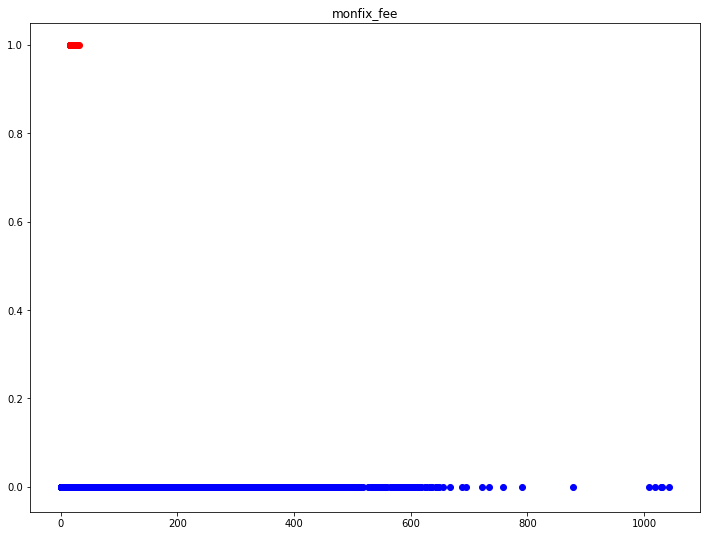

24.0    0.615809
16.0    0.245154
29.0    0.124833
26.0    0.007854
21.0    0.004512
25.0    0.000836
18.0    0.000501
17.0    0.000167
31.0    0.000167
19.0    0.000167
Name: monfix_fee, dtype: float64


38.0    0.070476
18.0    0.069631
8.0     0.064209
88.0    0.062802
58.0    0.060080
68.0    0.022494
48.0    0.020103
14.0    0.019032
Name: monfix_fee, dtype: float64

In [120]:
col = mff
tmp0 = datatr2[datatr2['label'] == 0]
tmp1 = datatr2[datatr2['label'] == 1]
plt.title(col)
plt.scatter(tmp0[col], tmp0['label'], c='b')
plt.scatter(tmp1[col], tmp1['label'], c='r')
plt.show()
print(tmp1[col].value_counts(normalize=True))
tmp0[col].value_counts(normalize=True).iloc[:20]

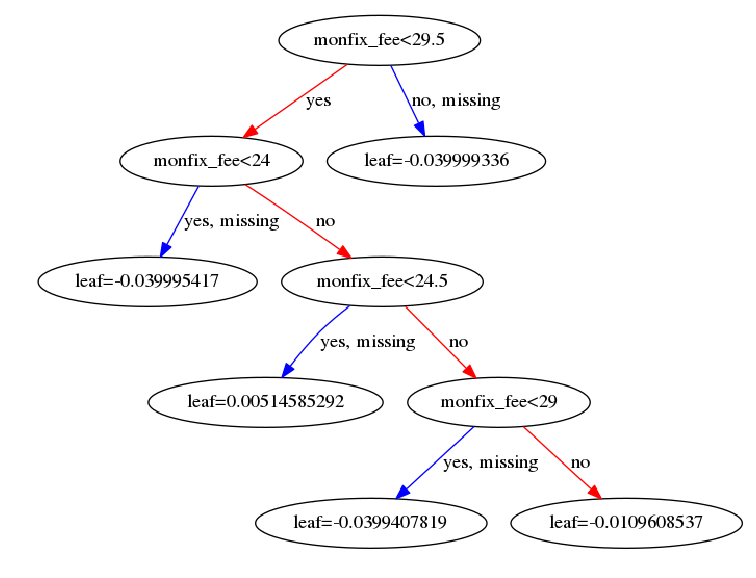

In [110]:
# 单独采用mff的分类树
clf = xgbplot(datatr1, [mff])

通过以上对比，我们可以看到1月2月数据分布差异较大，auc值高达0.59。同时，以1月为baseline进行预测，结果明显好于以2月为baseline的特征。两个数据集差异明显的重要原因在于monfix_fee特征差异较大， 同时monfix能够帮助识别羊毛党的重要取值为24。  
同时，训练集和测试集在monfix_fee也有很大的差异，训练集存在更多的空值。  
因此，之后的建模方向有两个：  
1.采用均值，最值等统计特征将monfix_fee的关键识别数值表现出来；  
2. 将monfix_fee为空的数据分离出来后另外进行训练。

**2.特征工程**  

In [114]:
for col in [acf, oacf, oacd]:
    data[col + '_isnan'] = data[col].apply(lambda x: 1 if np.isnan(x) else 0)
data['acfd'] = data[acf] / data[oacd]

In [115]:
data.loc[data['acfd'] == float('inf'), 'acfd'] = 0.11

In [116]:
cols = [c for c in data.columns if c not in ['phone', 'label', 'month']]
act_cols = [acf, oacd, oacf]
cat_cols = ['if_family', 'if_group', 'sms_inpkg_ind'] + [c + '_isnan' for c in act_cols]
num_cols = [c for c in cols if c not in cat_cols]
# num_cols_valued = [c for c in num_cols if c not in ['call_cnt', 'up_flux', 'down_flux']]

In [117]:
data1 = data.merge(train_label, on='phone', how='left')
datatr = data1[~data1['label'].isnull()]
datats = data1[data1['label'].isnull()]
datatr1 = datatr[datatr['month'] == 202001]
datatr2 = datatr[datatr['month'] == 202002]
datatr1.sort_values(by=['phone'], inplace=True)
datatr2.sort_values(by=['phone'], inplace=True)

datats3 = datats[datats['month'] == 202003]
datats4 = datats[datats['month'] == 202004]
datats3.sort_values(by=['phone'], inplace=True)
datats4.sort_values(by=['phone'], inplace=True)

In [118]:
datatr1.rename(columns={c:c+'_m1' for c in num_cols + cat_cols}, inplace=True)
datatr2.rename(columns={c:c+'_m2' for c in num_cols + cat_cols}, inplace=True)
datats3.rename(columns={c:c+'_m1' for c in num_cols + cat_cols}, inplace=True)
datats4.rename(columns={c:c+'_m2' for c in num_cols + cat_cols}, inplace=True)


In [119]:
datatr12 = datatr1.merge(datatr2, on='phone', how='left')
datats34 = datats3.merge(datats4, on='phone', how='left')


In [120]:
datatr12.rename(columns={'label_x':'label'}, inplace=True)
datats34.rename(columns={'label_x':'label'}, inplace=True)

In [121]:
for col in num_cols:
    datatr12[col + '_min'] = datatr12.apply(lambda df: minval(df[col + '_m1'], df[col + '_m2']), axis=1)
    datatr12[col + '_max'] = datatr12.apply(lambda df: maxval(df[col + '_m1'], df[col + '_m2']), axis=1)
    datatr12[col + '_mean'] = datatr12.apply(lambda df: meanval(df[col + '_m1'], df[col + '_m2']), axis=1)
for col in cat_cols:
    datatr12[col + '_cats'] = datatr12.apply(lambda df: catsval(df[col + '_m1'], df[col + '_m2']), axis=1)


In [ ]:
for col in num_cols:
    datats34[col + '_min'] = datats34.apply(lambda df: minval(df[col + '_m1'], df[col + '_m2']), axis=1)
    datats34[col + '_max'] = datats34.apply(lambda df: maxval(df[col + '_m1'], df[col + '_m2']), axis=1)
    datats34[col + '_mean'] = datats34.apply(lambda df: meanval(df[col + '_m1'], df[col + '_m2']), axis=1)
for col in cat_cols:
    datats34[col + '_cats'] = datats34.apply(lambda df: catsval(df[col + '_m1'], df[col + '_m2']), axis=1)

In [ ]:
# datatr12[['phone', 'label'] + num_cols_mean + num_cols_max + num_cols_min + cat_cols_cats].to_csv('dt12.csv', index=False)
# datats34[['phone', 'label'] + num_cols_mean + num_cols_max + num_cols_min + cat_cols_cats].to_csv('dt34.csv', index=False)

**3.模型训练**

In [17]:
# 训练集中两个月的monfix_fee都为空的用户没有羊毛党，但这并不绝对，会导致过拟合而降低测试集的效果
dnotnan = datatr12[~datatr12[mff + '_mean'].isnull()]
dnan = datatr12[datatr12[mff + '_mean'].isnull()]
dnan.label.sum()

In [122]:
num_cols_min = [c + '_min' for c in num_cols]
num_cols_mean = [c + '_mean' for c in num_cols]
num_cols_max = [c + '_max' for c in num_cols]
cat_cols_cats = [c + '_cats' for c in cat_cols]
cs = num_cols_min + num_cols_max + num_cols_mean + cat_cols_cats

In [123]:
f1value, impdic = xgbclf(datatr12, datatr12, init_cols=cs)
print(f1value)

[[85446    16]
 [   89  1132]]
[[85373    14]
 [  103  1193]]
[[85354    15]
 [  120  1194]]
[[85332    16]
 [  104  1230]]
[[85402    19]
 [  106  1155]]
0.9515159069368387


In [10]:
cs = [c for c in datatr12.columns if c not in ['label', 'phone']]
cs

['chrg_cnt_mean',
 'chrg_amt_mean',
 'gprs_fee_mean',
 'overrun_flux_fee_mean',
 'out_actvcall_dur_mean',
 'actvcall_fee_mean',
 'out_activcall_fee_mean',
 'monfix_fee_mean',
 'gift_acct_amt_mean',
 'call_cnt_mean',
 'up_flux_mean',
 'down_flux_mean',
 'p2psms_up_cnt_mean',
 'p2psms_cmnct_fee_mean',
 'p2psms_pkg_fee_mean',
 'chrg_cnt_max',
 'chrg_amt_max',
 'gprs_fee_max',
 'overrun_flux_fee_max',
 'out_actvcall_dur_max',
 'actvcall_fee_max',
 'out_activcall_fee_max',
 'monfix_fee_max',
 'gift_acct_amt_max',
 'call_cnt_max',
 'up_flux_max',
 'down_flux_max',
 'p2psms_up_cnt_max',
 'p2psms_cmnct_fee_max',
 'p2psms_pkg_fee_max',
 'chrg_cnt_min',
 'chrg_amt_min',
 'gprs_fee_min',
 'overrun_flux_fee_min',
 'out_actvcall_dur_min',
 'actvcall_fee_min',
 'out_activcall_fee_min',
 'monfix_fee_min',
 'gift_acct_amt_min',
 'call_cnt_min',
 'up_flux_min',
 'down_flux_min',
 'p2psms_up_cnt_min',
 'p2psms_cmnct_fee_min',
 'p2psms_pkg_fee_min',
 'if_family_cats',
 'if_group_cats',
 'sms_inpkg_ind_ca

In [11]:
aucvalue, trsimpdic = diff_trs(datatr12, datats34, cs)

In [12]:
trsimpdic

{'monfix_fee_mean': 14172,
 'monfix_fee_max': 12652,
 'monfix_fee_min': 10909,
 'up_flux_mean': 8834,
 'down_flux_mean': 7914,
 'actvcall_fee_mean': 7695,
 'p2psms_up_cnt_mean': 7688,
 'down_flux_min': 7509,
 'gprs_fee_mean': 7144,
 'out_actvcall_dur_mean': 7085,
 'out_actvcall_dur_max': 7028,
 'up_flux_max': 6958,
 'actvcall_fee_max': 6797,
 'down_flux_max': 6612,
 'gprs_fee_max': 6311,
 'up_flux_min': 6181,
 'call_cnt_mean': 5949,
 'out_actvcall_dur_min': 5895,
 'p2psms_up_cnt_max': 5873,
 'call_cnt_min': 5684,
 'call_cnt_max': 5278,
 'actvcall_fee_min': 5131,
 'p2psms_cmnct_fee_mean': 5089,
 'p2psms_cmnct_fee_max': 4934,
 'gprs_fee_min': 4643,
 'gift_acct_amt_mean': 4470,
 'p2psms_up_cnt_min': 4404,
 'out_activcall_fee_mean': 4329,
 'overrun_flux_fee_max': 4103,
 'out_activcall_fee_max': 4013,
 'overrun_flux_fee_mean': 3974,
 'gift_acct_amt_max': 3973,
 'chrg_amt_max': 3710,
 'chrg_amt_mean': 3392,
 'gift_acct_amt_min': 3278,
 'overrun_flux_fee_min': 2976,
 'if_family_cats': 2895,
 

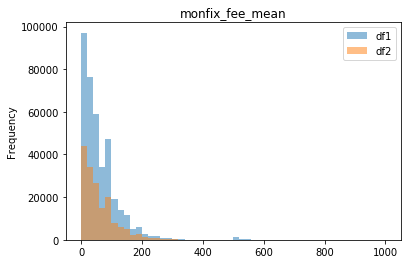

In [14]:
hist_2df(datatr12, datats34, mff + '_mean', 50)

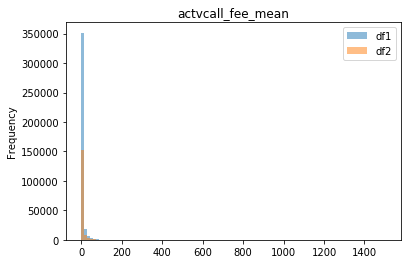

In [16]:
hist_2df(datatr12, datats34, acf + '_mean', 100)

In [50]:
tmp = [c for c in cols if c not in ['monfix_fee_mean', 'monfix_fee_max']]

In [51]:
f1value1, impdic1 = xgbclf(datatr12, datats34, init_cols=tmp)

[[85441    15]
 [   94  1133]]
[[85366    18]
 [  110  1189]]
[[85354    21]
 [  120  1188]]
[[85330    22]
 [  106  1224]]
[[85404    23]
 [  104  1151]]


In [52]:
f1value1

0.9490068893469565

In [53]:
datats34[datats34['pred'] > 0.5].shape[0] / datats34.shape[0]

0.011280983259967499

In [ ]:
datatr12[datatr12['pred'] > 0.5].shape[0] / datatr12.shape[0]

0.014828812241441766

In [ ]:
to_pred_sub = to_pred.merge(datats34, on='phone', how='left')
to_pred_sub = to_pred_sub[['phone', 'pred']]
to_pred_sub['label'] = to_pred_sub['pred'].apply(lambda x: 1 if x > 0.5 else 0)
to_pred_sub.drop(['pred'], axis=1, inplace=True)
to_pred_sub.to_csv('sheep1.csv', index=False)

In [ ]:
# res_dic = {}
# sets = set()
# datatr12_p1 = datatr12[datatr12['pred'] > 0.5]
# tmp0 = datatr12_p1[datatr12_p1['label'] < 0.5]
# tmp1 = datatr12_p1[datatr12_p1['label'] > 0.5]
# # for col in num_cols_valued:
# #     plt.title(col)
# #     plt.scatter(np.zeros(tmp0.shape[0]), tmp0[col + '_diff'].values)
# #     plt.scatter(np.ones(tmp1.shape[0]), tmp1[col + '_diff'].values)
# #     plt.show()
# #     mxv = tmp0[col + '_diff'].max()

# for col1 in num_cols_max + num_cols_min + num_cols_mean + num_cols_diff:
#     for col2 in num_cols_max + num_cols_min + num_cols_mean + num_cols_diff:
#         if col1 != col2 and (col2, col1) not in sets:
#             datatr12['tmp2'] = datatr12[col2].apply(lambda x: x if x > 0 else 1e-5)
#             datatr12[col1 + '__' + col2] = datatr12[col1] / datatr12['tmp2']
#             datatr12_p1 = datatr12[datatr12['pred'] > 0.5]
#             tmp0 = datatr12_p1[datatr12_p1['label'] < 0.5]
#             tmp1 = datatr12_p1[datatr12_p1['label'] > 0.5]
#             maxv, minv = tmp0[col1 + '__' +  col2].max(), tmp0[col1 + '__' +  col2].min()
#             res_dic[col1 + '__' + col2] = tmp1[(tmp1[col1 + '__' + col2] > maxv) | (tmp1[col1 + '__' + col2] < minv)].shape[0]
#             sets.add((col1, col2))
#             del datatr12_p1
#             del tmp0
#             del tmp1
#             gc.collect()
#     # print(col,' max exceed counts: ',tmp1[tmp1[col + '_diff'] > mxv].shape[0])
#     # print('------------')


In [ ]:
i = 0
for key in sorted([k for k in res_dic], key=lambda x:res_dic[x], reverse=True):
    print(key, res_dic[key])
    i += 1
    if i > 20:
        break

monfix_fee_min__out_activcall_fee_mean 149
out_activcall_fee_mean__monfix_fee_mean 149
out_activcall_fee_max__monfix_fee_min 43
out_activcall_fee_max__monfix_fee_mean 43
out_activcall_fee_min__monfix_fee_min 39
out_activcall_fee_min__monfix_fee_mean 39
out_actvcall_dur_max__out_activcall_fee_max 25
out_actvcall_dur_max__monfix_fee_max 25
out_actvcall_dur_max__gift_acct_amt_max 25
out_actvcall_dur_max__call_cnt_max 25
out_actvcall_dur_max__up_flux_max 25
out_actvcall_dur_max__down_flux_max 25
out_actvcall_dur_max__p2psms_cmnct_fee_max 25
out_actvcall_dur_max__p2psms_pkg_fee_max 25
out_actvcall_dur_max__chrg_cnt_min 25
out_actvcall_dur_max__chrg_amt_min 25
out_actvcall_dur_max__gprs_fee_min 25
out_actvcall_dur_max__overrun_flux_fee_min 25
out_actvcall_dur_max__out_activcall_fee_min 25
out_actvcall_dur_max__monfix_fee_min 25
out_actvcall_dur_max__gift_acct_amt_min 25


In [ ]:
# # 测试一下哪个缺失列填充什么有效果有效果
# fill_dic = {}
# for col in datatr.columns:
#     if datatr[col].isnull().sum() > 0:
#         for i, fv in enumerate([0, datatr[col].median(), datatr[col].mode()[0]]):
#             tmp = datatr.copy()
#             tmp[col] = tmp[col].fillna(fv)
#             r = xgbclf(tmp, tmp, cols1)
#             fill_dic[(col, i)] = r
#             del tmp
#             gc.collect()


In [ ]:
# c = monfix_fee_min__out_activcall_fee_mean 
c = 'out_activcall_fee_mean__monfix_fee_mean'
cs = c.split('__')


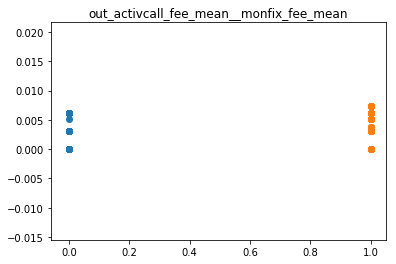

In [ ]:
tmp = datatr12[datatr12['pred'] > 0.5]
tmp0 = tmp[tmp['label'] < 0.5]
tmp1 = tmp[tmp['label'] > 0.5]
plt.title(c)
plt.scatter(np.zeros(tmp0.shape[0]), tmp0[c].values)
plt.scatter(np.ones(tmp1.shape[0]), tmp1[c].values)
plt.show()

In [ ]:
maxv, minv = tmp0[c].max(), tmp0[c].min()
print(minv, maxv)
maxv1, minv1 = tmp1[c].max(), tmp1[c].min()
print(minv1, maxv1)

df = tmp1[(tmp1[c] > maxv) | (tmp1[c] < minv)]

0.0 0.006185380134766244
0.0 0.007422456161719493


In [ ]:
df[['phone', 'pred', 'out_activcall_fee_m1', 'out_activcall_fee_m2', 'monfix_fee_m1', 'monfix_fee_m2']]

,phone,pred,out_activcall_fee_m1,out_activcall_fee_m2,monfix_fee_m1,monfix_fee_m2
732,00704522bc0c82146822a630179b81ce,0.998606,NaN,0.148449,24.0,16.0
1092,00a964c0dbd13efb2ac7eba0ae65a462,0.995964,0.148449,NaN,24.0,16.0
2097,0141a3cd69794a4f821f93fc980d8e2d,0.996180,NaN,0.148449,24.0,16.0
3574,021f57f4244531085016964db007a7d4,0.995396,NaN,0.148449,24.0,16.0
3731,02385b639e888bb0b1063fd6672721b8,0.995964,0.148449,NaN,24.0,16.0
8062,04c0a93daceec413834c6ec12e9414d8,0.998606,NaN,0.148449,24.0,16.0
10796,067111dbccfe31bab50d105ab87e1232,0.996180,NaN,0.148449,24.0,16.0
14045,085c7000798a39af6bc16aceb92be1f3,0.993836,NaN,0.148449,24.0,16.0
17695,0aa14e358526821194460f683e56a64c,0.996180,NaN,0.148449,24.0,16.0
24003,0e6acf83ab624f7b8884bf2a5708b8a8,0.991939,NaN,0.148449,24.0,16.0


In [ ]:
tmp = datatr12[(datatr12['label']==0) & (datatr12['pred']>0.5) & (datatr12['pred']<0.6)]
print(tmp.shape)
tmp = datatr12[(datatr12['label']==1) & (datatr12['pred']>0.5) & (datatr12['pred']<0.6)]
print(tmp.shape)

(45, 1885)
(57, 1885)


[[426940    126]
 [   489   5858]]


0.9501256994566539